In [1]:
import numpy as np
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d

import matplotlib

%matplotlib inline

print("CCL version you are using:",ccl.__version__)
print(ccl.__file__)

CCL version you are using: 2.0.1
/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1/envs/desc/lib/python3.7/site-packages/pyccl/__init__.py


In [2]:
import sys
#sys.path.insert(0, '/global/homes/z/zhzhuoqi/.local/cori/3.7-anaconda-2019.10/lib/python3.7/site-packages/TreeCorr-4.1-py3.7-linux-x86_64.egg')
sys.path.insert(0, '/global/u1/c/chihway/.local/lib/python2.7/site-packages/TreeCorr-4.1-py2.7-linux-x86_64.egg')

In [3]:
import treecorr
treecorr.__version__

'4.1'

In [4]:
import GCRCatalogs
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
import healpy as hp
import camb
import camb.correlations
import matplotlib.colors as clr
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, show, colorbar

This is the part for Treecorr measurement

In [5]:
def get_healpixel_footprint(ra, dec, nside, nest=False, count_threshold=None):
    pixels = hp.ang2pix(nside, ra, dec, nest=nest, lonlat=True)
    if count_threshold and count_threshold > 1:
        pixels, counts = np.unique(pixels, return_counts=True)
        return pixels[counts >= count_threshold]
    return np.unique(pixels)
def generate_uniform_random_ra_dec_healpixel(n, pix, nside, nest=False):

    ra, dec = hp.vec2ang(hp.boundaries(nside, pix, 1, nest=nest).T, lonlat=True)
    ra_dec_min_max = ra.min(), ra.max(), dec.min(), dec.max()

    ra = np.empty(n)
    dec = np.empty_like(ra)
    n_needed = n

    while n_needed > 0:
        ra_this, dec_this = generate_uniform_random_ra_dec_min_max(n_needed*2, *ra_dec_min_max)
        mask = np.where(hp.ang2pix(nside, ra_this, dec_this, nest=nest, lonlat=True) == pix)[0]
        count_this = mask.size
        if n_needed - count_this < 0:
            count_this = n_needed
            mask = mask[:n_needed]

        s = slice(-n_needed, -n_needed+count_this if -n_needed+count_this < 0 else None)
        ra[s] = ra_this[mask]
        dec[s] = dec_this[mask]
        n_needed -= count_this

    return ra, dec

def generate_uniform_random_ra_dec_min_max(n, ra_min, ra_max, dec_min, dec_max):

    ra = np.random.uniform(ra_min, ra_max, size=n)
    dec = np.random.uniform(np.sin(np.deg2rad(dec_min)), np.sin(np.deg2rad(dec_max)), size=n)
    dec = np.arcsin(dec, out=dec)
    dec = np.rad2deg(dec, out=dec)
    return ra, dec

def generate_uniform_random_ra_dec_footprint(n, footprint=None, nside=None, nest=False):

    if footprint is None or hp.nside2npix(nside) == len(footprint):
        return generate_uniform_random_ra_dec(n)

    n_per_pix_all = np.histogram(np.random.rand(n), np.linspace(0, 1, len(footprint)+1))[0]

    ra = np.empty(n)
    dec = np.empty_like(ra)
    count = 0

    for n_per_pix, pix in zip(n_per_pix_all, footprint):
        ra_this, dec_this = generate_uniform_random_ra_dec_healpixel(n_per_pix, pix, nside, nest)
        s = slice(count, count+n_per_pix)
        ra[s] = ra_this
        dec[s] = dec_this
        count += n_per_pix

    assert count == n

    return ra, dec

In [6]:
filename = '/global/projecta/projectdirs/lsst/groups/CS/cosmoDC2/mass_sheets_behind_z3/cmb_maps/cmblensmap_total_gausshiz_masked.fits'

In [7]:
mapfile = hp.read_map(filename)
print(len(mapfile))

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1/envs/desc/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
201326592


In [8]:
index = np.arange(201326592)
theta, phi = hp.pix2ang(nside=4096, ipix=index)

In [9]:
gc = GCRCatalogs.load_catalog('cosmoDC2')

In [10]:
data = gc.get_quantities(['ra', 'dec', 'shear_1', 'shear_2', 'redshift', 'mag_i_lsst'], filters=['mag_i_lsst<22'])

In [11]:
redshift_mask = (data['redshift']<0.62)*(data['redshift']>0.43)

In [12]:
#cut out the CosmoDC2 region from KCMB
nside = 512
healpix_id = get_healpixel_footprint(data['ra'][redshift_mask], data['dec'][redshift_mask], nside) 
print(healpix_id)
npix = hp.nside2npix(nside)
m = np.zeros(npix)
m[healpix_id]=1
new = hp.ud_grade(m, 4096)
cmb_mask = new>0
ra_K = np.degrees(phi[cmb_mask])
dec_K = np.degrees(np.pi/2-theta[cmb_mask])
kcmb = mapfile[cmb_mask]

[2227504 2227519 2227520 ... 2714575 2714591 2714592]


In [13]:
cat_N = treecorr.Catalog(ra=data['ra'][redshift_mask], dec=data['dec'][redshift_mask], ra_units='deg', dec_units='deg', npatch=40)
Npatch = cat_N.patch
Npatch_center = cat_N.get_patch_centers()

In [14]:
cat_K = treecorr.Catalog(ra=ra_K, dec=dec_K, k=kcmb, ra_units='deg', dec_units='deg', patch_centers=Npatch_center)
Kpatch=cat_K.patch

In [15]:
#generate random ra and dec
n = 10*len(data['ra'][redshift_mask])
nside = 512
ra_random, dec_random = generate_uniform_random_ra_dec_footprint(n, footprint=healpix_id, nside=nside, nest=False)

In [16]:
cat_N_random = treecorr.Catalog(ra=ra_random, dec=dec_random, ra_units='deg', dec_units='deg', patch_centers=Npatch_center)
Rpatch=cat_N_random.patch

In [17]:
nk_rand = treecorr.NKCorrelation(nbins=20, min_sep=(2.5/60)*(np.pi/180), max_sep=(250./60)*(np.pi/180), var_method='jackknife')

In [18]:
nk_rand.process(cat_N_random, cat_K)

In [19]:
nk_jk = treecorr.NKCorrelation(nbins=20, min_sep=(2.5/60)*(np.pi/180), max_sep=(250./60)*(np.pi/180), var_method='jackknife')

In [20]:
nk_jk.process(cat_N, cat_K)
nk_jk.calculateXi(rk=nk_rand)
xi_nk = nk_jk.xi
R_nk = np.exp(nk_jk.logr)
varxi_nk = nk_jk.varxi

In [21]:
cat_G = treecorr.Catalog(ra=data['ra'][redshift_mask], dec=data['dec'][redshift_mask],g1=data['shear_1'][redshift_mask], g2=data['shear_2'][redshift_mask], ra_units='deg', dec_units='deg', patch_centers=Npatch_center)

In [22]:
kg = treecorr.KGCorrelation(nbins=20, min_sep=(2.5/60)*(np.pi/180), max_sep=(250./60)*(np.pi/180), var_method='jackknife')

In [23]:
kg.process(cat_K, cat_G)
xi_kg = kg.xi
var_kg = kg.varxi
R_kg = np.exp(kg.logr)

## This is the ccl part

(100,) (101,)


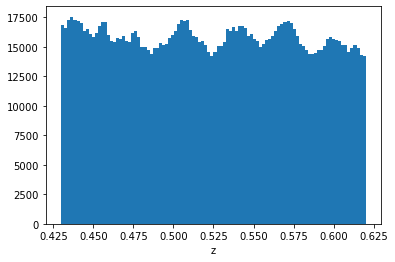

In [35]:
zhist = plt.hist(data['redshift'][redshift_mask], bins=100)
plt.xlabel('z')
print(zhist[0].shape, zhist[1].shape)
z = (zhist[1][1:]+zhist[1][:-1])/2
z_h = zhist[0]/np.sum(zhist[0])

In [36]:
# accuracy = 1e-3

# #load redshift distribution
# zhist = np.histogram(data['redshift'][redshift_mask],bins = 512)
# data_array = zhist[1]
# z = [sum(data_array[i:i + 2])/2 for i in range(len(data_array) - 2 + 1)]
# z_h = zhist[0]

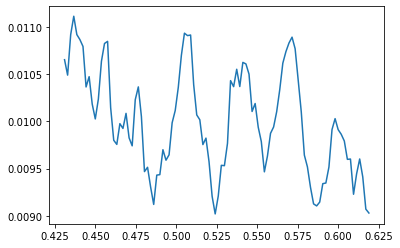

In [37]:
plt.plot(z, z_h)

#Bias parameters for these distributions
bz=np.ones_like(z_h)

In [107]:
#Initialize tracers
cosmo_cls=ccl.Cosmology(Omega_c=0.22, Omega_b=0.0045, Omega_g=0, Omega_k=0,
                          h=0.71, sigma8=0.8, n_s=0.963, Neff=0, m_nu=0.0,
                          w0=-1, wa=0, T_CMB=2.7, transfer_function='bbks',
                          mass_function='tinker')
cosmo_cls.cosmo.gsl_params.INTEGRATION_LIMBER_EPSREL = 1E-4
cosmo_cls.cosmo.gsl_params.INTEGRATION_EPSREL = 1E-4

In [108]:
ells=np.linspace(2,3000,2999).astype(int)

#Limber prefactors
lf_dl=(ells+0.5)**2/np.sqrt((ells+2.)*(ells+1.)*ells*(ells-1.))
lf_dc=(ells+0.5)**2/(ells*(ells+1.))
lf_ll=ells*(ells+1.)/np.sqrt((ells+2.)*(ells+1.)*ells*(ells-1.))

In [109]:
trcrs={}
trcrs['nc']=ccl.NumberCountsTracer(cosmo_cls,has_rsd=False,dndz=(z,z_h),bias=(z,bz))
trcrs['wl']=ccl.WeakLensingTracer(cosmo_cls,dndz=(z,z_h))
trcrs['cmbl']=ccl.CMBLensingTracer(cosmo_cls,1100.)

In [110]:
#CCL Power spectra
cl_ccl={}
cl_ccl['nc/cmbl']=ccl.angular_cl(cosmo_cls,trcrs['nc'],trcrs['cmbl'],ells)*lf_dc
cl_ccl['wl/cmbl']=ccl.angular_cl(cosmo_cls,trcrs['wl'],trcrs['cmbl'],ells)*lf_ll

win = hp.pixwin(4096)[:2999]
cl_ccl['nc/cmbl'] = cl_ccl['nc/cmbl']*win
cl_ccl['wl/cmbl'] = cl_ccl['wl/cmbl']*win

In [111]:
theta_deg = np.logspace(-1, 2.5, num=50)/60
print(theta_deg)

[1.66666667e-03 1.96461439e-03 2.31582582e-03 2.72982284e-03
 3.21782955e-03 3.79307654e-03 4.47115966e-03 5.27046277e-03
 6.21265620e-03 7.32328427e-03 8.63245780e-03 1.01756705e-02
 1.19947612e-02 1.41390483e-02 1.66666667e-02 1.96461439e-02
 2.31582582e-02 2.72982284e-02 3.21782955e-02 3.79307654e-02
 4.47115966e-02 5.27046277e-02 6.21265620e-02 7.32328427e-02
 8.63245780e-02 1.01756705e-01 1.19947612e-01 1.41390483e-01
 1.66666667e-01 1.96461439e-01 2.31582582e-01 2.72982284e-01
 3.21782955e-01 3.79307654e-01 4.47115966e-01 5.27046277e-01
 6.21265620e-01 7.32328427e-01 8.63245780e-01 1.01756705e+00
 1.19947612e+00 1.41390483e+00 1.66666667e+00 1.96461439e+00
 2.31582582e+00 2.72982284e+00 3.21782955e+00 3.79307654e+00
 4.47115966e+00 5.27046277e+00]


In [112]:
corr={}

ell = ells
cell = cl_ccl['nc/cmbl']
corr['nk'] = ccl.correlation(cosmo_cls, ell, cell, theta_deg, corr_type='GG', method='Bessel')

In [113]:
# help(ccl.correlation)

Help on function correlation in module pyccl.correlation:

correlation(cosmo, ell, C_ell, theta, corr_type='gg', method='fftlog')
    Compute the angular correlation function.
    
    Args:
        cosmo (:obj:`Cosmology`): A Cosmology object.
        ell (array_like): Multipoles corresponding to the input angular power
                          spectrum.
        C_ell (array_like): Input angular power spectrum.
        theta (float or array_like): Angular separation(s) at which to
                                     calculate the angular correlation
                                     function (in degrees).
        corr_type (string): Type of correlation function. Choices:
                            'GG' (galaxy-galaxy), 'GL' (galaxy-shear),
                            'L+' (shear-shear, xi+),
                            'L-' (shear-shear, xi-).
        method (string, optional): Method to compute the correlation function.
                                   Choices: 'Bessel' (dire

In [114]:
ell = ells
cell = cl_ccl['wl/cmbl']
corr['gk']=ccl.correlation(cosmo_cls, ell, cell, theta_deg, corr_type='GL', method='Bessel')

(-0.001, 0.004)

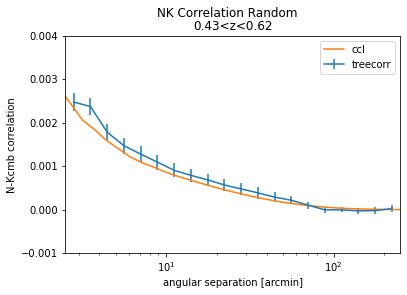

In [119]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.errorbar(np.degrees(R_nk)*60, xi_nk, yerr=np.sqrt(varxi_nk),label='treecorr')
ax.plot(theta_deg*60,corr['nk'],label='ccl')
ax.set_title('0.43<z<0.62')
ax.legend()
ax.set_xlabel('angular separation [arcmin]')
ax.set_ylabel('N-Kcmb correlation')
fig.suptitle('NK Correlation Random')
ax.set_xlim(2.5,250)
ax.set_ylim(-0.001,0.004)
#fig.savefig('NK4-6.png',dpi=200)

(-1e-06, 3e-05)

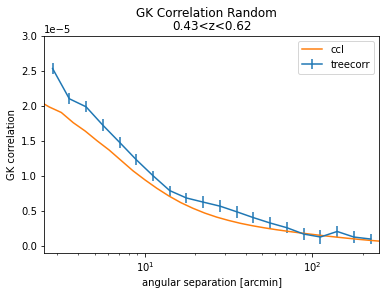

In [121]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.errorbar(np.degrees(R_kg)*60, xi_kg, yerr=np.sqrt(var_kg),label='treecorr')
ax.plot(theta_deg*60,corr['gk'],label='ccl')
ax.set_title('0.43<z<0.62')
ax.legend()
ax.set_xlabel('angular separation [arcmin]')
ax.set_ylabel('GK correlation')
fig.suptitle('GK Correlation Random')
ax.set_xlim(2.5,250)
ax.set_ylim(-0.000001,0.00003)
#fig.savefig('GK4-6.png',dpi=200)